In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import cv2
import pandas as pd
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mainPath = "/content/drive/MyDrive/Bakalaurinis/Final_code/"
# mainPath = "./dataset/"
testPath = os.path.join(mainPath, "my_test_images/images")
df = pd.read_csv(os.path.join(mainPath, "my_test_images/test.csv"))

In [5]:
model = tf.keras.models.load_model(os.path.join(mainPath, "models/EfficientNetV2/EfficientNetV2S.h5"))

In [6]:
input_shape = model.input_shape[1:4]

In [ ]:
indextest = 87
image = np.array(load_img(os.path.join(testPath, df['image_id'][indextest]), target_size=input_shape))
# plt.imshow(image)
# print(df['label'][indextest])

In [209]:
# [layer.name for layer in model.layers]

In [210]:
last_conv_layer = model.get_layer('top_conv')
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [211]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ['top_bn', 'top_activation', 'global_average_pooling2d', 'dense', 'dense_1']:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [212]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [213]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [214]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [215]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [216]:
gradcam = np.mean(last_conv_layer_output, axis=-1)
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, input_shape[:2])

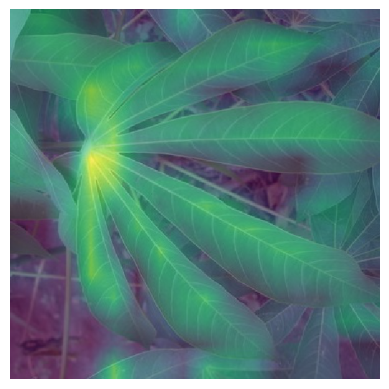

In [217]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.6)
plt.axis('off')
plt.show()